In [179]:
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import scipy.stats
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

PLOT_SETTINGS = {
    0: {
        "colour": [(0.122, 0.467, 0.706, 1.0), (0.122, 0.467, 0.706, 0.25)],
        "label": "Daugaard-Jensen",
    },
    1: {
        "colour": [(1.0, 0.498, 0.055, 1.0), (1.0, 0.498, 0.055, 0.25)],
        "label": "Uunartit Islands",
    },
}

plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15


def xcorr_lags(x, y):
    lags = np.arange(-10, 10)
    r2 = np.zeros_like(lags, dtype=float)
    p = np.zeros_like(lags, dtype=float)
    psig = np.zeros_like(lags, dtype=str)

    for i, lag in enumerate(lags):
        y_shifted = y.shift(time=lag)

        mask = x.notnull() & y_shifted.notnull()
        x_masked = x.where(mask, drop=True)
        y_shifted = y_shifted.where(mask, drop=True)
        print(lag, len(x_masked), len(y_shifted))

        res = scipy.stats.linregress(x_masked, y_shifted)
        r2[i] = res.rvalue
        p[i] = res.pvalue
        psig[i] = "sig" if res.pvalue < 0.05 else "notsig"

    return lags, r2, p, psig


def xcorr_plot(x, y, title="Cross-correlation"):
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    axs = [ax0, ax1]

    for i, ax in enumerate(axs):
        x_ = x.isel(glacier=i)
        y_ = y.isel(glacier=i)

        mask = x_.notnull() & y_.notnull()
        x_ = x_.where(mask, drop=True)
        y_ = y_.where(mask, drop=True)

        lags, r2, p, psig = xcorr_lags(x_, y_)

        for lag_val, r2_val, psig_val in zip(lags, r2, psig):
            marker, stem, _ = ax.stem(lag_val, r2_val, markerfmt="o")
            markerfacecolour = "none" if not psig_val else PLOT_SETTINGS[i]["colour"][0]
            plt.setp(
                marker, markerfacecolor=markerfacecolour, markeredgecolor=PLOT_SETTINGS[i]["colour"][0], markersize=8
            )
            plt.setp(stem, color=PLOT_SETTINGS[i]["colour"][0])
            marker.set_clip_on(False)
            marker.set_zorder(10)
            stem.set_clip_on(False)
            stem.set_zorder(10)

        ax.set_ylim(-1, 1)
        ax.axhline(y=0, color="black", alpha=0.8, linewidth=0.8, zorder=1)

        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
        ax.grid(True, which="major", axis="both", c="gray", linestyle=":", linewidth=0.5, alpha=0.8, zorder=0)
        ax.add_artist(AnchoredText("(x)", loc="upper left", borderpad=0.1, prop=dict(weight="semibold"), frameon=False))

    axs[1].tick_params(labelleft=False)
    axs[0].set_title(title)
    axs[0].set_ylabel("Correlation coefficient", size=14)

    plt.show()

-10 27 27
-9 28 28
-8 29 29
-7 30 30
-6 31 31
-5 32 32
-4 33 33
-3 34 34
-2 35 35
-1 36 36
0 37 37
1 36 36
2 35 35
3 34 34
4 33 33
5 32 32
6 31 31
7 30 30
8 29 29
9 28 28
10 27 27


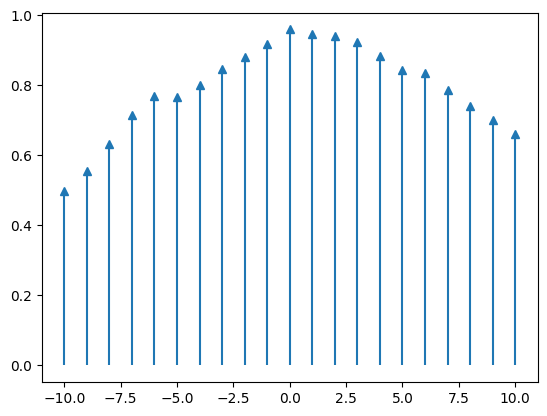

In [79]:
import xarray as xr

discharge = xr.open_dataset("../data/discharge/discharge_monthly_1986_2024.nc")
discharge = discharge.discharge.sel(glacier="UNNAMED_UUNARTIT_ISLANDS")
discharge = discharge.resample(time="1YS").mean()

vel = xr.open_dataset("../data/velocity/velocity_subannual_1985_2022.nc")
vel = vel.rename(mid_date="time")
vel = vel.sel(glacier="UNNAMED_UUNARTIT_ISLANDS", cd=1_000)
vel = vel.where(vel.date_dt.dt.days <= 30, drop=True)
velocity = vel.sortby("time").v.resample(time="1MS").mean().squeeze()
velocity = velocity.resample(time="1YS").mean().squeeze()

mask = velocity.notnull() & discharge.notnull()
velocity = velocity.where(mask, drop=True)
discharge = discharge.where(mask, drop=True)

lags, r2, p, psig = xcorr_lags(velocity, discharge)

In [74]:
list(zip(lags, r2, p, psig))

[(-10, 0.49679648624025247, 0.00838705801720375, 's'),
 (-9, 0.5548072571027407, 0.0021831695898569805, 's'),
 (-8, 0.6326590001810944, 0.00023087146895720424, 's'),
 (-7, 0.7135830371440879, 9.564376113253013e-06, 's'),
 (-6, 0.7686794782231364, 4.405846530503383e-07, 's'),
 (-5, 0.7649452089716601, 3.431363663494036e-07, 's'),
 (-4, 0.8020445805754869, 2.007649307534781e-08, 's'),
 (-3, 0.8473725459057754, 2.6061870990079614e-10, 's'),
 (-2, 0.8809901816812904, 2.920141784845723e-12, 's'),
 (-1, 0.9185609177889327, 2.900253879329367e-15, 's'),
 (0, 0.9591056946273385, 9.0998344639309e-21, 's'),
 (1, 0.9469974733287322, 2.440811882861457e-18, 's'),
 (2, 0.9404717919824869, 4.9869895746685496e-17, 's'),
 (3, 0.9238100339668375, 6.841966779127436e-15, 's'),
 (4, 0.8837029451316767, 9.590415305310327e-12, 's'),
 (5, 0.8445025802385194, 1.235634714805686e-09, 's'),
 (6, 0.8354461498704746, 5.0109836643483724e-09, 's'),
 (7, 0.7869755706996644, 2.498537271847706e-07, 's'),
 (8, 0.739719327

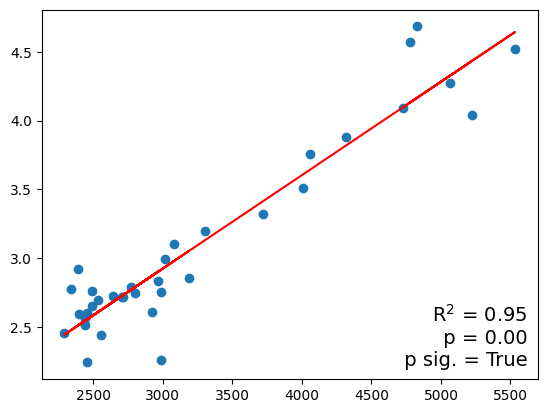

In [42]:
# pearsonr(x[valid_idx], y_shifted[valid_idx])
d = discharge.shift(time=1)

mask = velocity.notnull() & d.notnull()
velocity = velocity.where(mask, drop=True)
d = d.where(mask, drop=True)

res = scipy.stats.linregress(velocity, d)
plt.plot(velocity, d, "o")
plt.plot(velocity, res.intercept + res.slope * velocity, "r", label="fitted line")

plt.gca().add_artist(
    AnchoredText(
        f"R$^{{2}}$ = {res.rvalue:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
        loc="lower right",
        borderpad=0.1,
        prop=dict(fontsize=14, horizontalalignment="right"),
        frameon=False,
    )
)

In [ ]:
list(zip(lags, corr))

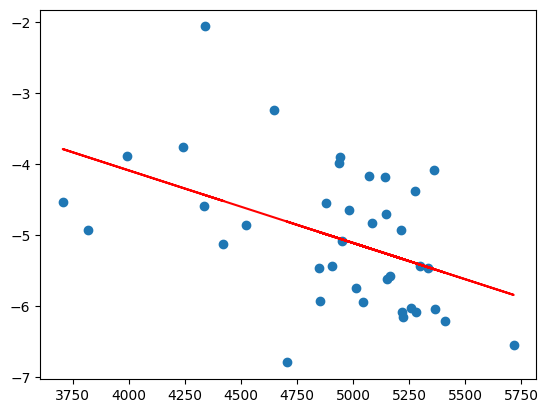

In [20]:
import geopandas as gpd
import pandas as pd

boxes_gdf = gpd.read_file("../data/terminus/terminus_boxes_1985_2023.geojson")
boxes_gdf["date"] = pd.to_datetime(boxes_gdf.date)
x = boxes_gdf.set_index(["date"]).to_xarray()
x = x.where(x.glacier == "DAUGAARD-JENSEN")
x = x.sortby("date")
x["area_width_averaged"] = x.area_width_averaged.astype(float)
baseline = slice("1985-01-01", "2024-01-01")
r_monthly = x.area_width_averaged.resample(date="1MS").mean()
r_baseline = r_monthly.sel(date=baseline).groupby("date.month").mean()
r_anomalies = r_monthly.groupby("date.month") - r_baseline

air = xr.open_dataset("../data/air/air_temp_monthly_1980_2024.nc")
air = air.sel(glacier="DAUGAARD-JENSEN")
air = air.sel(time=slice(r_monthly.date.min().values, r_monthly.date.max().values))

r_monthly = r_monthly.rename(date="time")

r_monthly = r_monthly.resample(time="1YS").mean()
air = air.t_monthly.resample(time="1YS").mean()

mask = ~np.isnan(air) & ~np.isnan(r_monthly)
air = air.where(mask, drop=True)
r_monthly = r_monthly.where(mask, drop=True)

res = scipy.stats.linregress(r_monthly, air)
plt.plot(r_monthly, air, "o")
plt.plot(r_monthly, res.intercept + res.slope * r_monthly, "r", label="fitted line")

In [21]:
res

LinregressResult(slope=-0.0010217840546969104, intercept=-0.000845127501528431, rvalue=-0.4671364024175323, pvalue=0.0031084673079739265, stderr=0.0003223349753035718, intercept_stderr=1.5912778998618946)

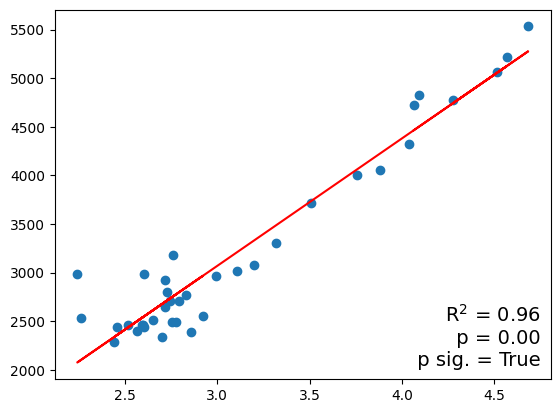

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from matplotlib.offsetbox import AnchoredText

discharge = xr.open_dataset("../data/discharge/discharge_monthly_1986_2024.nc")
discharge = discharge.discharge.sel(glacier="UNNAMED_UUNARTIT_ISLANDS")
discharge = discharge.resample(time="1YS").mean()

vel = xr.open_dataset("../data/velocity/velocity_subannual_1985_2022.nc")
vel = vel.rename(mid_date="time")
vel = vel.sel(glacier="UNNAMED_UUNARTIT_ISLANDS", cd=1_000)
vel = vel.where(vel.date_dt.dt.days <= 30, drop=True)
velocity = vel.sortby("time").v.resample(time="1MS").mean().squeeze()
velocity = velocity.resample(time="1YS").mean().squeeze()

mask = velocity.notnull() & discharge.notnull()
velocity = velocity.where(mask, drop=True)
discharge = discharge.where(mask, drop=True)

res = scipy.stats.linregress(discharge, velocity)
plt.plot(discharge, velocity, "o")
plt.plot(discharge, res.intercept + res.slope * discharge, "r", label="fitted line")

plt.gca().add_artist(
    AnchoredText(
        f"R$^{{2}}$ = {res.rvalue:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
        loc="lower right",
        borderpad=0.1,
        prop=dict(fontsize=14, horizontalalignment="right"),
        frameon=False,
    )
)

In [30]:
res

LinregressResult(slope=1310.4654062624493, intercept=-862.4036416907975, rvalue=0.9591056946273385, pvalue=9.0998344639309e-21, stderr=65.37104394313349, intercept_stderr=207.83513951426164)

In [18]:
3.0182471435533915e-124

3.0182471435533915e-124

C:\Users\olive\AppData\Local\Temp\ipykernel_32644\1885918694.py:46: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))


-10 6 6
-9 7 7
-8 8 8
-7 9 9
-6 10 10
-5 11 11
-4 12 12
-3 13 13
-2 14 14
-1 15 15
0 16 16
1 15 15
2 14 14
3 13 13
4 12 12
5 11 11
6 10 10
7 9 9
8 8 8
9 7 7
10 6 6


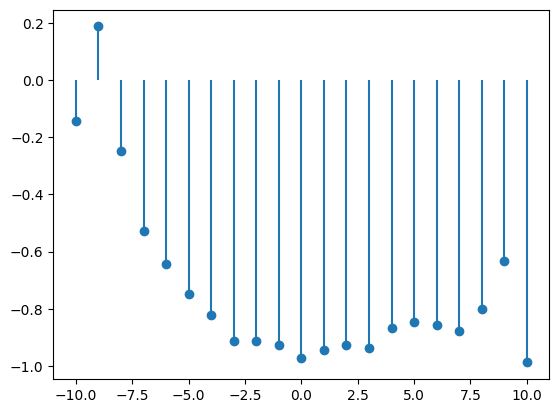

In [127]:
import scipy.signal as signal
import numpy as np
import scipy.stats


def xcorr_lags(x, y):
    """
    Compute Pearson correlation coefficients for different lags.
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    c    : Pearson correlation coefficients for each lag
    """
    lags = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    r2 = np.zeros_like(lags, dtype=float)
    p = np.zeros_like(lags, dtype=float)
    psig = np.zeros_like(lags, dtype=bool)

    for i, lag in enumerate(lags):
        y_shifted = y.shift(time=lag)

        mask = x.notnull() & y_shifted.notnull()
        x_masked = x.where(mask, drop=True)
        y_shifted = y_shifted.where(mask, drop=True)
        print(lag, len(x_masked), len(y_shifted))

        res = scipy.stats.linregress(x_masked, y_shifted)
        r2[i] = res.rvalue
        p[i] = res.pvalue
        psig[i] = True if res.pvalue < 0.05 else False

    return lags, r2, p, psig


# Open and merge ArcticDEM and ASTERDEM elevation samples into one Dataset
arctic_ds = xr.open_dataset("../data/elevation/arcticdem/elevation_arcticdem_points.nc")
aster_ds = xr.open_dataset("../data/elevation/asterdem/elevation_asterdem_points.nc")
elevation_ds = xr.combine_by_coords([arctic_ds, aster_ds], combine_attrs="drop_conflicts")

# Calculate change in elevation relative to the first observation at each centreline point
elevation_ds_stack = elevation_ds.stack(glacier_cd=["glacier", "cd"]).compute()
elevation_ds_stack = elevation_ds_stack.where(elevation_ds_stack.h.notnull(), drop=True)
h = elevation_ds_stack.h.groupby("glacier_cd")
h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))
dh = h - h_baseline
elevation_ds["dh_merged"] = dh.unstack("glacier_cd").transpose("glacier", "cd", "time")
elevation_ds = elevation_ds.isel(glacier=1)
elevation = elevation_ds.where(elevation_ds.coreg_rmse < 100).sel(cd=1_000)
elevation = elevation.dh_merged.squeeze().sel(time=elevation_ds.dh_merged.time.dt.month.isin([5, 6, 7, 8, 9]))
elevation = elevation.resample(time="1YS").mean()


vel = xr.open_dataset("../data/velocity/velocity_subannual_1985_2022.nc")
vel = vel.rename(mid_date="time")
vel = vel.sel(glacier="UNNAMED_UUNARTIT_ISLANDS", cd=1_000)
vel = vel.where(vel.date_dt.dt.days <= 30, drop=True)
velocity = vel.sortby("time").v.resample(time="1MS").mean().squeeze()
velocity = velocity.resample(time="1YS").mean().squeeze()

mask = velocity.notnull() & elevation.notnull()
velocity = velocity.where(mask, drop=True)
elevation = elevation.where(mask, drop=True)

lags, r2, p, psig = xcorr_lags(elevation, velocity)

plt.figure()
for lag_val, r2_val, psig_val in zip(lags, r2, psig):
    marker = "^" if psig_val == "s" else "o"
    plt.stem(lag_val, r2_val, markerfmt=marker)

plt.show()

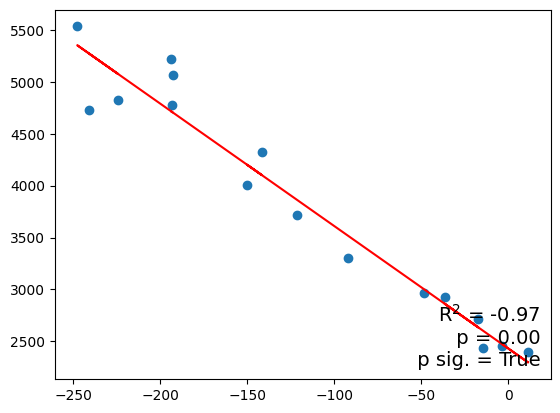

In [85]:
res = scipy.stats.linregress(elevation, velocity)
plt.plot(elevation, velocity, "o")
plt.plot(elevation, res.intercept + res.slope * elevation, "r", label="fitted line")

plt.gca().add_artist(
    AnchoredText(
        f"R$^{{2}}$ = {res.rvalue:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
        loc="lower right",
        borderpad=0.1,
        prop=dict(fontsize=14, horizontalalignment="right"),
        frameon=False,
    )
)

In [128]:
psig

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True])

C:\Users\olive\AppData\Local\Temp\ipykernel_32644\3814228433.py:46: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))


-10 7 7
-9 8 8
-8 9 9
-7 10 10
-6 11 11
-5 12 12
-4 13 13
-3 14 14
-2 15 15
-1 16 16
0 17 17
1 16 16
2 15 15
3 14 14
4 13 13
5 12 12
6 11 11
7 10 10
8 9 9
9 8 8
10 7 7


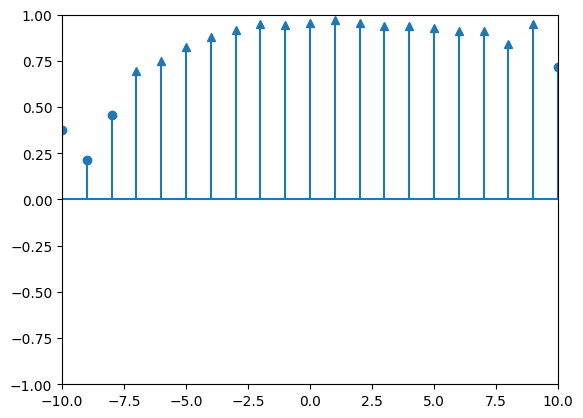

In [97]:
import scipy.signal as signal
import numpy as np
import scipy.stats


def xcorr_lags(x, y):
    """
    Compute Pearson correlation coefficients for different lags.
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    c    : Pearson correlation coefficients for each lag
    """
    lags = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    r2 = np.zeros_like(lags, dtype=float)
    p = np.zeros_like(lags, dtype=float)
    psig = np.zeros_like(lags, dtype=str)

    for i, lag in enumerate(lags):
        y_shifted = y.shift(time=lag)

        mask = x.notnull() & y_shifted.notnull()
        x_masked = x.where(mask, drop=True)
        y_shifted = y_shifted.where(mask, drop=True)
        print(lag, len(x_masked), len(y_shifted))

        res = scipy.stats.linregress(x_masked, y_shifted)
        r2[i] = res.rvalue
        p[i] = res.pvalue
        psig[i] = "sig" if res.pvalue < 0.05 else "notsig"

    return lags, r2, p, psig


# Open and merge ArcticDEM and ASTERDEM elevation samples into one Dataset
arctic_ds = xr.open_dataset("../data/elevation/arcticdem/elevation_arcticdem_points.nc")
aster_ds = xr.open_dataset("../data/elevation/asterdem/elevation_asterdem_points.nc")
elevation_ds = xr.combine_by_coords([arctic_ds, aster_ds], combine_attrs="drop_conflicts")

# Calculate change in elevation relative to the first observation at each centreline point
elevation_ds_stack = elevation_ds.stack(glacier_cd=["glacier", "cd"]).compute()
elevation_ds_stack = elevation_ds_stack.where(elevation_ds_stack.h.notnull(), drop=True)
h = elevation_ds_stack.h.groupby("glacier_cd")
h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))
dh = h - h_baseline
elevation_ds["dh_merged"] = dh.unstack("glacier_cd").transpose("glacier", "cd", "time")
elevation_ds = elevation_ds.isel(glacier=1)
elevation = elevation_ds.where(elevation_ds.coreg_rmse < 100).sel(cd=1_000)
elevation = elevation.dh_merged.squeeze().sel(time=elevation_ds.dh_merged.time.dt.month.isin([5, 6, 7, 8, 9]))
elevation = elevation.resample(time="1YS").mean()

# Load terminus change data
terminus_ds = xr.open_dataset("../data/terminus/terminus_1985_2023.nc").isel(glacier=1)
retreat = terminus_ds.area_width_averaged_change.resample(time="1YS").mean()

mask = retreat.notnull() & elevation.notnull()
retreat = retreat.where(mask, drop=True)
elevation = elevation.where(mask, drop=True)

lags, r2, p, psig = xcorr_lags(elevation, retreat)

plt.figure()
for lag_val, r2_val, psig_val in zip(lags, r2, psig):
    marker = "^" if psig_val == "s" else "o"
    plt.stem(lag_val, r2_val, markerfmt=marker)
plt.xlim(-10, 10)
plt.ylim(-1, 1)
plt.gca().set_clip_on(False)
plt.axhline(y=0)
plt.show()

In [168]:
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker

PLOT_SETTINGS = {
    0: {
        "colour": [(0.122, 0.467, 0.706, 1.0), (0.122, 0.467, 0.706, 0.25)],
        "label": "Daugaard-Jensen",
    },
    1: {
        "colour": [(1.0, 0.498, 0.055, 1.0), (1.0, 0.498, 0.055, 0.25)],
        "label": "Uunartit Islands",
    },
}

plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

# Set up axes
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
axs = [ax0, ax1]

arctic_ds = xr.open_dataset("../data/elevation/arcticdem/elevation_arcticdem_points.nc")
aster_ds = xr.open_dataset("../data/elevation/asterdem/elevation_asterdem_points.nc")
elevation_ds = xr.combine_by_coords([arctic_ds, aster_ds], combine_attrs="drop_conflicts")
elevation_ds_stack = elevation_ds.stack(glacier_cd=["glacier", "cd"]).compute()
elevation_ds_stack = elevation_ds_stack.where(elevation_ds_stack.h.notnull(), drop=True)
h = elevation_ds_stack.h.groupby("glacier_cd")
h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))
dh = h - h_baseline
elevation_ds["dh_merged"] = dh.unstack("glacier_cd").transpose("glacier", "cd", "time")

terminus_ds = xr.open_dataset("../data/terminus/terminus_1985_2023.nc")


for i, ax in enumerate(axs):
    elevation = elevation_ds.isel(glacier=i)
    elevation = elevation.where(elevation.coreg_rmse < 100).sel(cd=1_000)
    elevation = elevation.dh_merged.squeeze().sel(time=elevation_ds.dh_merged.time.dt.month.isin([5, 6, 7, 8, 9]))
    elevation = elevation.resample(time="1YS").mean()

    retreat = terminus_ds.isel(glacier=i)
    retreat = retreat.area_width_averaged_change.resample(time="1YS").mean()

    mask = retreat.notnull() & elevation.notnull()
    retreat = retreat.where(mask, drop=True)
    elevation = elevation.where(mask, drop=True)

    lags, r2, p, psig = xcorr_lags(retreat, elevation)

    for lag_val, r2_val, psig_val in zip(lags, r2, psig):
        marker, stem, _ = ax.stem(lag_val, r2_val, markerfmt="o")
        markerfacecolour = "none" if not psig_val else PLOT_SETTINGS[i]["colour"][0]
        plt.setp(marker, markerfacecolor=markerfacecolour, markeredgecolor=PLOT_SETTINGS[i]["colour"][0], markersize=8)
        plt.setp(stem, color=PLOT_SETTINGS[i]["colour"][0])
        marker.set_clip_on(False)
        marker.set_zorder(10)
        stem.set_clip_on(False)
        stem.set_zorder(10)

    # ax.set_title(glacier, fontsize=14)
    # ax.set_xlabel("Year")
    ax.set_ylim(-1, 1)
    ax.axhline(y=0, color="black", alpha=0.8, linewidth=0.8, zorder=1)

    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
    ax.grid(True, which="major", axis="both", c="gray", linestyle=":", linewidth=0.5, alpha=0.8, zorder=0)
    ax.add_artist(AnchoredText("(x)", loc="upper left", borderpad=0.1, prop=dict(weight="semibold"), frameon=False))


axs[1].tick_params(labelleft=False)
axs[0].set_ylabel("Correlation coefficient", size=14)

plt.show()

C:\Users\olive\AppData\Local\Temp\ipykernel_32644\2366439494.py:38: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))


-10 12 12
-9 13 13
-8 14 14
-7 15 15
-6 16 16
-5 17 17
-4 18 18
-3 19 19
-2 20 20
-1 21 21
0 22 22
1 21 21
2 20 20
3 19 19
4 18 18
5 17 17
6 16 16
7 15 15
8 14 14
9 13 13
10 12 12
-10 7 7
-9 8 8
-8 9 9
-7 10 10
-6 11 11
-5 12 12
-4 13 13
-3 14 14
-2 15 15
-1 16 16
0 17 17
1 16 16
2 15 15
3 14 14
4 13 13
5 12 12
6 11 11
7 10 10
8 9 9
9 8 8
10 7 7


In [166]:
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker

PLOT_SETTINGS = {
    0: {
        "colour": [(0.122, 0.467, 0.706, 1.0), (0.122, 0.467, 0.706, 0.25)],
        "label": "Daugaard-Jensen",
    },
    1: {
        "colour": [(1.0, 0.498, 0.055, 1.0), (1.0, 0.498, 0.055, 0.25)],
        "label": "Uunartit Islands",
    },
}

plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15


def xcorr_plot(x, y, title="Cross-correlation"):
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    axs = [ax0, ax1]

    for i, ax in enumerate(axs):
        x_ = x.isel(glacier=i)
        y_ = y.isel(glacier=i)

        mask = x_.notnull() & y_.notnull()
        x_ = x_.where(mask, drop=True)
        y_ = y_.where(mask, drop=True)

        lags, r2, p, psig = xcorr_lags(x_, y_)

        for lag_val, r2_val, psig_val in zip(lags, r2, psig):
            marker, stem, _ = ax.stem(lag_val, r2_val, markerfmt="o")
            markerfacecolour = "none" if not psig_val else PLOT_SETTINGS[i]["colour"][0]
            plt.setp(
                marker, markerfacecolor=markerfacecolour, markeredgecolor=PLOT_SETTINGS[i]["colour"][0], markersize=8
            )
            plt.setp(stem, color=PLOT_SETTINGS[i]["colour"][0])
            marker.set_clip_on(False)
            marker.set_zorder(10)
            stem.set_clip_on(False)
            stem.set_zorder(10)

        ax.set_ylim(-1, 1)
        ax.axhline(y=0, color="black", alpha=0.8, linewidth=0.8, zorder=1)

        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
        ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
        ax.grid(True, which="major", axis="both", c="gray", linestyle=":", linewidth=0.5, alpha=0.8, zorder=0)
        ax.add_artist(AnchoredText("(x)", loc="upper left", borderpad=0.1, prop=dict(weight="semibold"), frameon=False))

    axs[1].tick_params(labelleft=False)
    axs[0].set_title(title)
    axs[0].set_ylabel("Correlation coefficient", size=14)

    plt.show()

In [174]:
arctic_ds = xr.open_dataset("../data/elevation/arcticdem/elevation_arcticdem_points.nc")
aster_ds = xr.open_dataset("../data/elevation/asterdem/elevation_asterdem_points.nc")
elevation_ds = xr.combine_by_coords([arctic_ds, aster_ds], combine_attrs="drop_conflicts")
elevation_ds_stack = elevation_ds.stack(glacier_cd=["glacier", "cd"]).compute()
elevation_ds_stack = elevation_ds_stack.where(elevation_ds_stack.h.notnull(), drop=True)
h = elevation_ds_stack.h.groupby("glacier_cd")
h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))
dh = h - h_baseline
elevation_ds["dh_merged"] = dh.unstack("glacier_cd").transpose("glacier", "cd", "time")
elevation = elevation_ds.where(elevation_ds.coreg_rmse < 100).sel(cd=1_000)
elevation = elevation.dh_merged.squeeze().sel(time=elevation_ds.dh_merged.time.dt.month.isin([5, 6, 7, 8, 9]))
elevation = elevation.resample(time="1YS").mean()

terminus_ds = xr.open_dataset("../data/terminus/terminus_1985_2023.nc")
retreat = terminus_ds.area_width_averaged_change.resample(time="1YS").mean()

xcorr_plot(retreat, elevation, "Ra v. Es-1000")

C:\Users\olive\AppData\Local\Temp\ipykernel_32644\581034568.py:7: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))


-10 12 12
-9 13 13
-8 14 14
-7 15 15
-6 16 16
-5 17 17
-4 18 18
-3 19 19
-2 20 20
-1 21 21
0 22 22
1 21 21
2 20 20
3 19 19
4 18 18
5 17 17
6 16 16
7 15 15
8 14 14
9 13 13
10 12 12
-10 7 7
-9 8 8
-8 9 9
-7 10 10
-6 11 11
-5 12 12
-4 13 13
-3 14 14
-2 15 15
-1 16 16
0 17 17
1 16 16
2 15 15
3 14 14
4 13 13
5 12 12
6 11 11
7 10 10
8 9 9
9 8 8
10 7 7


In [175]:
arctic_ds = xr.open_dataset("../data/elevation/arcticdem/elevation_arcticdem_points.nc")
aster_ds = xr.open_dataset("../data/elevation/asterdem/elevation_asterdem_points.nc")
elevation_ds = xr.combine_by_coords([arctic_ds, aster_ds], combine_attrs="drop_conflicts")
elevation_ds_stack = elevation_ds.stack(glacier_cd=["glacier", "cd"]).compute()
elevation_ds_stack = elevation_ds_stack.where(elevation_ds_stack.h.notnull(), drop=True)
h = elevation_ds_stack.h.groupby("glacier_cd")
h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))
dh = h - h_baseline
elevation_ds["dh_merged"] = dh.unstack("glacier_cd").transpose("glacier", "cd", "time")
elevation = elevation_ds.where(elevation_ds.coreg_rmse < 100).sel(cd=20_000)
elevation = elevation.dh_merged.squeeze()  # .sel(time=elevation_ds.dh_merged.time.dt.month.isin([5, 6, 7, 8, 9]))
elevation = elevation.resample(time="1YS").mean()

terminus_ds = xr.open_dataset("../data/terminus/terminus_1985_2023.nc")
retreat = terminus_ds.area_width_averaged_change.resample(time="1YS").mean()

xcorr_plot(retreat, elevation, "Ra v. Es-20000")

C:\Users\olive\AppData\Local\Temp\ipykernel_32644\517972587.py:7: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))


-10 12 12
-9 13 13
-8 14 14
-7 15 15
-6 16 16
-5 17 17
-4 18 18
-3 19 19
-2 20 20
-1 21 21
0 22 22
1 21 21
2 20 20
3 19 19
4 18 18
5 17 17
6 16 16
7 15 15
8 14 14
9 13 13
10 12 12
-10 11 11
-9 12 12
-8 13 13
-7 14 14
-6 15 15
-5 16 16
-4 17 17
-3 18 18
-2 19 19
-1 20 20
0 21 21
1 20 20
2 19 19
3 18 18
4 17 17
5 16 16
6 15 15
7 14 14
8 13 13
9 12 12
10 11 11


In [180]:
discharge = xr.open_dataset("../data/discharge/discharge_monthly_1986_2024.nc")
discharge = discharge.discharge.resample(time="1YS").mean()

vel = xr.open_dataset("../data/velocity/velocity_subannual_1985_2022.nc")
vel = vel.rename(mid_date="time")
vel = vel.sel(cd=1_000)
vel = vel.where(vel.date_dt.dt.days <= 30, drop=True)
velocity = vel.sortby("time").v.resample(time="1MS").mean().squeeze()
velocity = velocity.resample(time="1YS").mean().squeeze()

xcorr_plot(velocity, discharge, "Ra v. Es-20000")

-10 27 27
-9 28 28
-8 29 29
-7 30 30
-6 31 31
-5 32 32
-4 33 33
-3 34 34
-2 35 35
-1 36 36
0 37 37
1 36 36
2 35 35
3 34 34
4 33 33
5 32 32
6 31 31
7 30 30
8 29 29
9 28 28
-10 27 27
-9 28 28
-8 29 29
-7 30 30
-6 31 31
-5 32 32
-4 33 33
-3 34 34
-2 35 35
-1 36 36
0 37 37
1 36 36
2 35 35
3 34 34
4 33 33
5 32 32
6 31 31
7 30 30
8 29 29
9 28 28


In [ ]:
import matplotlib.pyplot as plt
import scipy
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Set up axes
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(nrows=1, ncols=1)
ax0 = fig.add_subplot(gs[0, 0])

# Load discharge data
velocity_ds = xr.open_dataset("../data/velocity/velocity_subannual_1985_2022.nc")
velocity_ds = velocity_ds.sel(cd=1_000, mid_date=slice("2000-01-01", "2024-01-01"))
velocity_ds = velocity_ds.where(velocity_ds.date_dt.dt.days <= 30, drop=True)
velocity_ds = velocity_ds.resample(mid_date="1MS").mean("mid_date")

a = velocity_ds.isel(glacier=0).v
b = velocity_ds.isel(glacier=1).v

# Mask null values
mask = a.notnull() & b.notnull()
a = a.where(mask, drop=True)
b = b.where(mask, drop=True)

# Regress discharge against year
res = scipy.stats.linregress(a, b)

# Plot data and trendline
ax0.plot(a, b, "o")
ax0.plot(a, res.intercept + res.slope * a, "r", label="fitted line")

# Add R2 and p values to plot
ax0.add_artist(
    AnchoredText(
        f"R = {res.rvalue:.2f}\n R$^{{2}}$ = {res.rvalue**2:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
        loc="lower right",
        borderpad=0.1,
        prop=dict(fontsize=14, horizontalalignment="right"),
        frameon=False,
    )
)

# Label plots
ax0.set_title(glacier, fontsize=14)
ax0.set_xlabel("Year")

ax0.set_ylabel("Velocity [m a-1]", size=14)

plt.show()